### Oxygen Evals in PugetSound (data from Dakota - UW)

In [1]:
import xarray as xr
import netCDF4 as nc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

import cmocean.cm as cm
import copy

from salishsea_tools import visualisations as vis
from salishsea_tools import viz_tools

import datetime as dt
import arrow
import copy
import math
import matplotlib.dates as mdates
import gsw
from mpl_toolkits.basemap import Basemap
import matplotlib.patches as mpatches
import scipy.stats as stat

In [2]:
def calc_stats(x, y):
    stats = {}
    MSE = np.mean((y - x)**2)
    stats['RMSE'] = np.sqrt(MSE)
    stats['bias'] = np.mean(y) - np.mean(x)
    stats['WSS'] = 1 - MSE / np.mean((abs(y - np.mean(x)) + abs(x - np.mean(x)))**2)
    
    return stats


def plot_panel(ax, x, y, lims, units):
    stats = calc_stats(x, y)

    statstext = f"RMSE = {stats['RMSE']:.3f} {units}\nbias = {stats['bias']:.3f} {units}\nWSS = {stats['WSS']:.3f}"
    
    props = dict(boxstyle='round', facecolor='w', alpha=0.9)
    c = ax.text(0.01, 0.8, statstext, bbox=props, transform=ax.transAxes, fontsize=9)
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    
    return c

In [3]:
mesh = nc.Dataset('/ocean/atall/MOAD/grid/mesh_mask202108.nc')
bathy = nc.Dataset('/ocean/atall/MOAD/grid/bathymetry_202108.nc')

meshb = nc.Dataset('/ocean/atall/MOAD/grid/mesh_mask_202310b.nc')
bathyb = nc.Dataset('/ocean/atall/MOAD/grid/bathymetry_202310b.nc')
grid = xr.open_dataset('/ocean/atall/MOAD/grid/bathymetry_202310b.nc', mask_and_scale=False)

depthb = meshb.variables['gdept_0'][:]
with xr.open_dataset('/ocean/atall/MOAD/grid/mesh_mask_202310b.nc') as mesh:
    tmask = mesh.tmask
    mbathy = mesh.mbathy
    long = mesh.nav_lon
    latg = mesh.nav_lat
grid_dir = Path("/ocean/atall/MOAD/grid/")
grid_map = Path("grid_from_lat_lon_mask999.nc")
grid_lons_lats = xr.open_dataset(grid_dir / grid_map)

In [4]:
ctdd = pd.read_pickle('/ocean/atall/MOAD/Obs/ecology_fromDakota_UW/ctd_1999_2016_fixed.p')
ctd17 = pd.read_pickle('/ocean/atall/MOAD/Obs/ecology_fromDakota_UW/ctd_2017_fixed.p')
ctd18 = pd.read_pickle('/ocean/atall/MOAD/Obs/ecology_fromDakota_UW/ctd_2018_fixed.p')
ctd19 = pd.read_pickle('/ocean/atall/MOAD/Obs/ecology_fromDakota_UW/ctd_2019_fixed.p')
bot = pd.read_pickle('/ocean/atall/MOAD/Obs/ecology_fromDakota_UW/bottle_2006_2017_fixed.p')
sta_df = pd.read_pickle('/ocean/atall/MOAD/Obs/ecology_fromDakota_UW/sta_df.p')

sta_df


,Lat_NAD83 (deg / dec_min),Long_NAD83 (deg / dec_min),Desig,Descrip,Basin,Max_Depth
Station,,,,,,
ADM001,48 1.7888,122 37.076,C,Admiralty Inlet - Bush Pt.,Admiralty Inlet,114
ADM002,48 11.2391,122 50.577,C,Admiralty Inlet (north) - Quimper Pn.,Admiralty Inlet,79
ADM003,47 52.739,122 28.9917,C,Admiralty Inlet (south),Admiralty Inlet,118
BLL009,48 41.1564,122 35.9771,C,Bellingham Bay - Pt. Frances,Strait of Georgia,31
BUD005,47 5.5224,122 55.0918,C,Budd Inlet - Olympia Shoal,South Basin,22
CMB003,47 17.4226,122 27.0074,C,Commencement Bay - Browns Point,Main Basin,123
CRR001,47 16.5891,122 42.5745,C,Carr Inlet - Off Green Point,South Basin,110
CSE001,47 15.8724,122 50.6583,C,Case Inlet - S. Heron Island,South Basin,65
DNA001,47 9.689,122 52.3083,C,Dana Passage - S. of Brisco Point,South Basin,41


In [78]:
ctd17

,ResultID,Station,Date,Depth,Year,Temp,Salinity,Density,Chla_adjusted,DO_raw,DO_sat,Xmiss_25cm,Turbidity,Rep
0,949802,ADM001,2017-02-23,1.0,2017,7.9416,28.7327,22.3643,0.834954,8.0805,82.134,90.1144,0.9164,1
1,949803,ADM001,2017-02-23,1.5,2017,7.9260,28.8211,22.4357,0.821487,8.0863,82.212,90.0204,0.8519,1
2,949804,ADM001,2017-02-23,2.0,2017,7.9191,28.9219,22.5157,0.848421,8.0414,81.796,89.9304,0.7375,1
3,949805,ADM001,2017-02-23,2.5,2017,7.9197,28.9308,22.5225,0.851114,8.0342,81.729,90.0212,0.7440,1
4,949806,ADM001,2017-02-23,3.0,2017,7.9188,28.9360,22.5268,0.851114,8.0201,81.587,90.3787,0.7199,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57167,989776,WPA113,2017-12-12,9.0,2017,8.7509,26.9623,20.8676,2.652999,9.3231,95.421,74.7846,2.1270,1
57168,989777,WPA113,2017-12-12,9.5,2017,8.7543,26.9701,20.8732,2.644919,9.2689,94.878,74.6224,2.2840,1
57169,989778,WPA113,2017-12-12,10.0,2017,8.7579,26.9766,20.8777,2.650306,9.3505,95.725,74.5888,2.3027,1
57170,989779,WPA113,2017-12-12,10.5,2017,8.7648,26.9925,20.8892,2.679933,9.4234,96.496,74.0974,2.7872,1


In [4]:
# Put coordonates in dataframe --- matching with model
Lat=dict()
Lon=dict()
for alpha in range(0,5):
    if alpha==0:
        ctd=ctdd
        filename = 'ctd_1999-2016'
        ctd['DO_adjusted']=ctd.DO_adjusted*44.661
    elif alpha==1:
        ctd=ctd17
        filename = 'ctd_2017'
        ctd['DO_raw']=ctd.DO_raw*44.661
    elif alpha==2:
        ctd=ctd18
        filename = 'ctd_2018'
        ctd['DO_adjusted']=ctd.DO_adjusted*44.661
    elif alpha==3:
        ctd=ctd19
        filename = 'ctd_2019'
        ctd['DO_raw']=ctd.DO_raw*44.661
    else:
        ctd=bot
        filename = 'bot_2006-2017'

    for i in range(0,len(ctd.Station)):
        if ctd.Station[i]=='ADM001':
            Lat[i] = 48.0298133333
            Lon[i] = -122.6179333333
        elif ctd.Station[i]=='ADM002':
            Lat[i] = 48.1873183333
            Lon[i] = -122.84295
        elif ctd.Station[i]=='ADM003':
            Lat[i] = 47.8789833333
            Lon[i] = -122.483195
        elif ctd.Station[i]=='BLL009':
            Lat[i] = 48.68594
            Lon[i] = -122.5996183333
        elif ctd.Station[i]=='BUD005':
            Lat[i] = 47.09204
            Lon[i] = -122.9181966667
        elif ctd.Station[i]=='CMB003':
            Lat[i] = 47.2903766667
            Lon[i] = -122.4501233333
        elif ctd.Station[i]=='CRR001':
            Lat[i] = 47.276485
            Lon[i] = -122.709575
        elif ctd.Station[i]=='CSE001':
            Lat[i] = 47.26454
            Lon[i] = -122.844305
        elif ctd.Station[i]=='DNA001':
            Lat[i] = 47.1614833333
            Lon[i] = -122.871805
        elif ctd.Station[i]=='EAP001':
            Lat[i] = 47.4170433333
            Lon[i] = -122.3804016667
        elif ctd.Station[i]=='ELB015':
            Lat[i] = 47.5964866667
            Lon[i] = -122.3695716667
        elif ctd.Station[i]=='GOR001':
            Lat[i] = 47.1831516667
            Lon[i] = -122.6345716667
        elif ctd.Station[i]=='GRG002':
            Lat[i] = 48.80816
            Lon[i] = -122.9540766667
        elif ctd.Station[i]=='GYS004':
            Lat[i] = 46.97787
            Lon[i] = -123.78461
        elif ctd.Station[i]=='GYS008':
            Lat[i] = 46.9373133333
            Lon[i] = -123.9132233333
        elif ctd.Station[i]=='GYS016':
            Lat[i] = 46.9534216667
            Lon[i] = -124.09295
        elif ctd.Station[i]=='HCB003':
            Lat[i] = 47.53787
            Lon[i] = -123.0096
        elif ctd.Station[i]=='HCB004':
            Lat[i] = 47.356205
            Lon[i] = -123.0248733333
        elif ctd.Station[i]=='HCB007':
            Lat[i] = 47.3981483333
            Lon[i] = -122.9295916667
        elif ctd.Station[i]=='HCB010':
            Lat[i] = 47.67
            Lon[i] = -122.82
        elif ctd.Station[i]=='NSQ002':
            Lat[i] = 47.1673166667
            Lon[i] = -122.78819
        elif ctd.Station[i]=='OAK004':
            Lat[i] = 47.2134266667
            Lon[i] = -123.07765
        elif ctd.Station[i]=='PSB003':
            Lat[i] = 47.6598183333
            Lon[i] = -122.4429083333
        elif ctd.Station[i]=='PSS019':
            Lat[i] = 48.0109266667
            Lon[i] = -122.30125
        elif ctd.Station[i]=='PTH005':
            Lat[i] = 48.0831483333
            Lon[i] = -122.7646116667
        elif ctd.Station[i]=='RSR837':
            Lat[i] = 48.6164916667
            Lon[i] = -122.7629583333
        elif ctd.Station[i]=='SAR003':
            Lat[i] = 48.107595
            Lon[i] = -122.4915416667
        elif ctd.Station[i]=='SIN001':
            Lat[i] = 47.5492616667
            Lon[i] = -122.6434716667
        elif ctd.Station[i]=='SJF000':
            Lat[i] = 48.4166666667
            Lon[i] = -123.025
        elif ctd.Station[i]=='SJF001':
            Lat[i] = 48.3333333333
            Lon[i] = -123.025
        elif ctd.Station[i]=='SJF002':
            Lat[i] = 48.25
            Lon[i] = -123.025
        elif ctd.Station[i]=='SKG003':
            Lat[i] = 48.2964883333
            Lon[i] = -122.489605
        elif ctd.Station[i]=='WPA001':
            Lat[i] = 46.6873216667
            Lon[i] = -123.7498816667
        elif ctd.Station[i]=='WPA003':
            Lat[i] = 46.7039866667
            Lon[i] = -123.837385
        elif ctd.Station[i]=='WPA004':
            Lat[i] = 46.6867633333
            Lon[i] = -123.9735
        elif ctd.Station[i]=='WPA006':
            Lat[i] = 46.5453766667
            Lon[i] = -123.9801616667
        elif ctd.Station[i]=='WPA007':
            Lat[i] = 46.453155
            Lon[i] = -124.0096033333
        elif ctd.Station[i]=='WPA008':
            Lat[i] = 46.463155
            Lon[i] = -123.9412683333
        elif ctd.Station[i]=='WPA113':
            Lat[i] = 46.644
            Lon[i] = -123.993
    ctd['Lat']=Lat
    ctd['Lon']=Lon

    #ctd.to_pickle('/ocean/atall/MOAD/Obs/ecology_fromDakota_UW/fixedTall/{}.p'.format(f'{filename}'))

In [41]:
# hourly matching data
ctd202111 = pd.read_csv('/ocean/atall/MOAD/ObsModel/202111/ObsModel_202111_ctd_from_UW_20130101_20131231.csv')
ctd202410 = pd.read_csv('/ocean/atall/MOAD/ObsModel/202410/ObsModel_202410_ctd_from_UW_20130101_20131231.csv')
# daily matching data
#ctd202111 = pd.read_csv('/ocean/atall/MOAD/ObsModel/202111daily/ObsModel_201905_ctd_from_UW_20130101_20131231.csv')
#ctd202410 = pd.read_csv('/ocean/atall/MOAD/ObsModel/202410daily/ObsModel_202410_ctd_from_UW_20130101_20131231.csv')


/tmp/ipykernel_2897362/493565530.py:4: UserWarning: linewidths is ignored by contourf
  ax.contourf(long, latg, mbathy[0,:,:], linewidths=1, levels=[-0.01, 0.01], colors='whitesmoke')


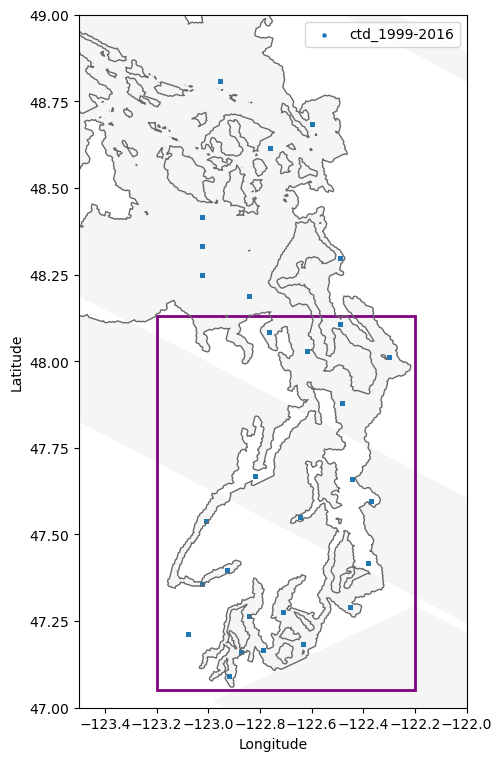

In [42]:
fig, ax = plt.subplots(1,1,figsize=(5, 9))
lon1,lon2,lat1,lat2 = (-123.2,-122.2,47.05,48.13)

ax.contourf(long, latg, mbathy[0,:,:], linewidths=1, levels=[-0.01, 0.01], colors='whitesmoke')
ax.contour(long, latg, mbathy[0,:,:], linewidths=1, levels=[-0.01, 0.01], colors='dimgray')
#ax.contour(grid.lon_rho, grid.lat_rho,grid.h, linewidths=1, levels=[200, 1000, 2000], colors='dimgray', alpha=0.5)
ax.set_ylabel('Latitude')
ax.set_xlabel('Longitude')
ax.set_ylim([47,49])
ax.set_xlim([-123.5,-122])
#ax.set_ylim([48,51])
#ax.set_xlim([-125,-122])

# plot the location of observations
ax.scatter(ctd202111.Lon, ctd202111.Lat, s=5, label="ctd_1999-2016")

#ax.scatter(ncei_bot.Lon[ncei_bot.name != 'ctd'], ncei_bot.Lat[ncei_bot.name != 'ctd'], s=2, label="ncei-bot")
#ax.scatter(bot.Lon, bot.Lat, s=2, label="bot")
ax.legend()

left, bottom, width, height = (lon2, lat1, lon1-lon2, lat2-lat1)
rect=mpatches.Rectangle((left,bottom),width,height, 
                        fill=False,
                        #alpha=0.1
                        color="purple",
                       linewidth=2,
                       label="Puget Sound")

plt.gca().add_patch(rect)

In [43]:
df_21 = ctd202111[ ctd202111['Lon'].between(lon1, lon2) & ctd202111['Lat'].between(lat1, lat2) ]
df_24 = ctd202410[ ctd202410['Lon'].between(lon1, lon2) & ctd202410['Lat'].between(lat1, lat2) ]


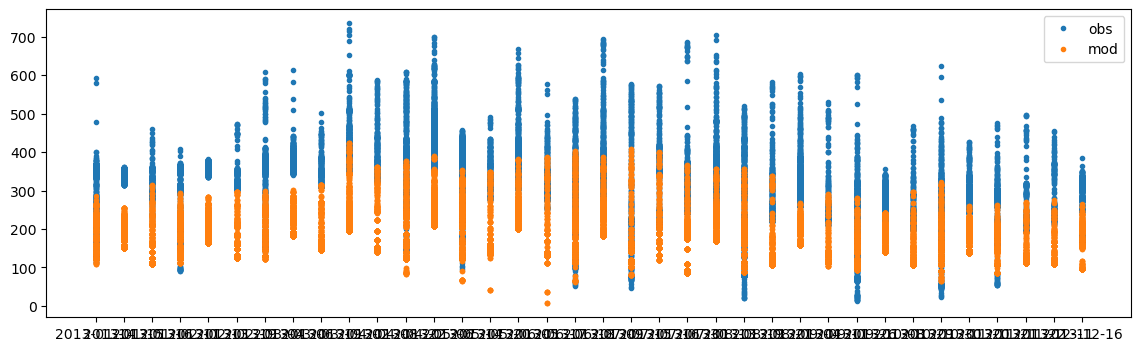

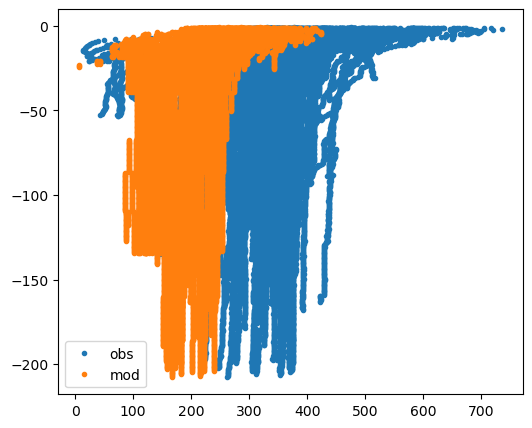

In [44]:
fig, ax = plt.subplots(1, 1, figsize=(14, 4))
ax.plot(df_24.dtUTC, df_24.Oxygen_Dissolved ,'.', label='obs')
ax.plot(df_24.dtUTC, df_24.mod_dissolved_oxygen,'.', label='mod')
ax.legend()
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
ax.plot(df_24.Oxygen_Dissolved, -df_24.Z, '.',label='obs')
ax.plot(df_24.mod_dissolved_oxygen, -df_24.Z, '.', label='mod')
ax.legend()

In [45]:
def profiles(tracer,colour,ax):
    if tracer == 'Salinity':
        t_obs = 'Salinity'
        t_mod = 'mod_vosaline'
        unit = 'g/kg'
        unity ='meter'
    elif tracer == 'DO':
        t_obs = 'Oxygen_Dissolved'
        t_mod = 'mod_dissolved_oxygen'
        unit = 'uM'
        unity ='meter'

    avg_obs, binsa, _ = stat.binned_statistic(-df_21['Z'][(np.isfinite(df_21[t_obs]))],df_21[t_obs][(np.isfinite(df_21[t_obs]))],statistic='mean',bins=100)
    avg_21, bins, _ = stat.binned_statistic(-df_21['Z'][(np.isfinite(df_21[t_mod]))],df_21[t_mod][(np.isfinite(df_21[t_mod]))],statistic='mean',bins=100)
    avg_24, binsa, _ = stat.binned_statistic(-df_24['Z'][(np.isfinite(df_24[t_mod]))],df_24[t_mod][(np.isfinite(df_24[t_mod]))],statistic='mean',bins=100)

    ax.plot(avg_obs, binsa[:-1], lw=2,label='obs')
    ax.plot(avg_21, bins[:-1], lw=2,label='202111')
    ax.plot(avg_24, binsa[:-1], lw=2,label='202410')

    title = tracer
    #ax.set_title(title)
    ax.set_xlabel(unit)
    ax.set_ylabel(unity)

2018


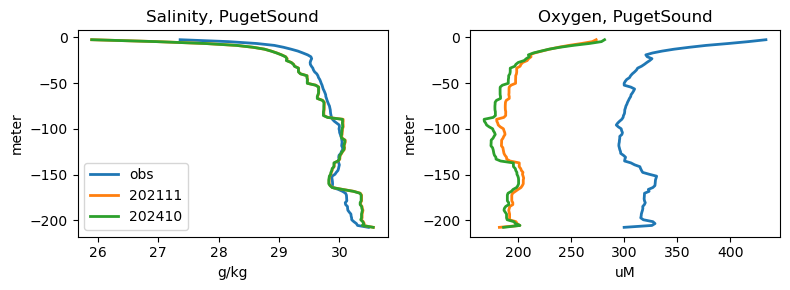

In [47]:
print('2018')
i, j = (0, 1)
fig, ax = plt.subplots(1, 2, figsize=(8,3))

title = 'Salinity, PugetSound'
ax[i].set_title(title,fontsize=12)

title = 'Oxygen, PugetSound'
ax[j].set_title(title,fontsize=12)

# plot profiles Saaanich Inlet

profiles('Salinity','k',ax[0])
profiles('DO','k',ax[1])
ax[0].legend()
plt.tight_layout()

